In [185]:
import pandas as pd
import  sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [186]:
def getLastMatchesAgainst(matches, date, home_team, away_team, n_matches = 10):

    #obtain the matches of both teams 
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    #concatenate the tables
    total_matches = pd.concat([home_matches, away_matches])
    
    #sorting by time and the limit of matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n_matches,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
            
    #Return data
    return last_matches

In [187]:
def getLastMatches(matches, date, team, n_matches):
    #Obtaining the n matches in a period of time 
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]         
    return team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n_matches,:]
    

In [188]:
def getGoals(matches, team):
    #Obtaining the number of goals of a team playing as home or away 
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())
    return  home_goals + away_goals

def getGoalsAgaints(matches, team):
    #Get the goals against of a specfic team from a set of matches.
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())
    return home_goals + away_goals

def getWins(matches, team):
    #Get the wins of a team in a set of matches
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())
    return home_wins + away_wins

def setLabel(match):
    #Set the label deppending on the difference of goals 
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id']  
    
    difference = match['home_team_goal'] - match['away_team_goal']
    if difference > 0:
        label.loc[0,'home_wdl'] = "W"
    elif difference == 0:
        label.loc[0,'home_wdl'] = "D"
    else:
        label.loc[0,'home_wdl'] = "L"
       
    return label.loc[0]

In [189]:
def getPlayerStats(match, player_stats):   
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    home_players = ["home_player_" + str(x) for x in range(1, 12)]
    away_players = ["away_player_" + str(x) for x in range(1, 12)]
    players = home_players + away_players

    #Creating the new Data Frame 
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        player_id = match[player]
        stats = player_stats[player_stats.player_api_id == player_id]      
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        name = "{}_overall_rating".format(player)
        names.append(name)
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id
    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.loc[0]    

In [190]:
def getFeatures(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
   
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    #Obtaining last matches 
    matches_home_team = getLastMatches( matches,date, home_team, n_matches = x)
    matches_away_team = getLastMatches( matches,date, away_team, n_matches = x)
    #Obtaining all the goals of that matches 
    home_goals = getGoals(matches_home_team, home_team)
    away_goals = getGoals(matches_away_team, away_team)
    home_goals_against = getGoalsAgaints(matches_home_team, home_team)
    away_goals_against = getGoalsAgaints(matches_away_team, away_team)
    #Obtaining the mathches against each other 
    last_matches_against = getLastMatchesAgainst(matches,date, home_team, away_team, n_matches = 5)
    

    feature = pd.DataFrame()
    
    #Creating features
    feature.loc[0, 'match_api_id'] = match.match_api_id
    feature.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_against
    feature.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_against
    feature.loc[0, 'games_against_won'] = getWins(last_matches_against, home_team)
    feature.loc[0, 'games_against_lost'] = getWins(last_matches_against, away_team)
    feature.loc[0, 'home_team_games_won'] = getWins(matches_home_team, home_team) 
    feature.loc[0, 'away_team_games_qon'] = getWins(matches_away_team, away_team)
   
    #Return match features
    return feature.loc[0]

In [191]:


#Obtain the features 
match_stats = match_table.apply(lambda x: getFeatures(x, match_table, x = 10), axis = 1)
player_stats = match_table.apply(lambda x: getPlayerStats(x, player_table), axis = 1)

#genereta the match labels 
labels = match_table.apply(setLabel, axis = 1)

#Merges everything into a final data frame
df_final = pd.merge(match_stats, player_stats, on = 'match_api_id', how = 'left')
df_final = pd.merge(df_final, labels, on = 'match_api_id', how = 'left')
df_final.dropna(inplace = True)


In [192]:
#CREATING THE TRAIN AND TEST SETS 
y = df_final["home_wdl"].values
df_final.pop("home_wdl")
df_final.fillna(0)


,match_api_id,home_team_goals_difference,away_team_goals_difference,games_against_won,games_against_lost,home_team_games_won,away_team_games_qon,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,1775146.0,4.0,-5.0,0.0,1.0,4.0,2.0,75.0,76.0,73.0,...,71.0,64.0,67.0,57.0,68.0,64.0,60.0,68.0,71.0,70.0
1,1775147.0,3.0,6.0,0.0,0.0,3.0,4.0,60.0,55.0,62.0,...,52.0,70.0,71.0,65.0,51.0,67.0,69.0,69.0,64.0,72.0
2,1775148.0,2.0,-4.0,0.0,0.0,3.0,1.0,60.0,58.0,62.0,...,57.0,60.0,54.0,64.0,56.0,61.0,52.0,65.0,62.0,64.0
3,1775149.0,1.0,-6.0,0.0,0.0,2.0,1.0,61.0,52.0,55.0,...,67.0,63.0,70.0,58.0,63.0,67.0,65.0,59.0,67.0,70.0
4,1775150.0,1.0,-2.0,0.0,0.0,2.0,0.0,62.0,58.0,52.0,...,57.0,62.0,62.0,63.0,64.0,65.0,49.0,70.0,65.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1992086.0,14.0,1.0,1.0,1.0,8.0,4.0,75.0,71.0,64.0,...,52.0,57.0,52.0,65.0,58.0,65.0,64.0,61.0,64.0,64.0
96,1992087.0,-2.0,-5.0,2.0,0.0,3.0,1.0,71.0,57.0,70.0,...,57.0,60.0,56.0,58.0,63.0,61.0,52.0,66.0,54.0,62.0
97,1992088.0,5.0,10.0,0.0,0.0,5.0,6.0,60.0,66.0,62.0,...,58.0,65.0,64.0,60.0,66.0,79.0,69.0,58.0,72.0,70.0
98,1992089.0,-4.0,-9.0,1.0,0.0,3.0,2.0,61.0,52.0,62.0,...,62.0,55.0,56.0,58.0,64.0,64.0,64.0,61.0,64.0,67.0


In [193]:
#USING RANDOM FOREST 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("Train " + str(accuracy_score(y_train, y_pred)))
y_pred = clf.predict(X_test)
print("Test " + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test,y_pred))



Train 1.0
Test 0.6
              precision    recall  f1-score   support

           D       0.00      0.00      0.00         5
           L       0.83      0.62      0.71         8
           W       0.50      1.00      0.67         7

    accuracy                           0.60        20
   macro avg       0.44      0.54      0.46        20
weighted avg       0.51      0.60      0.52        20



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

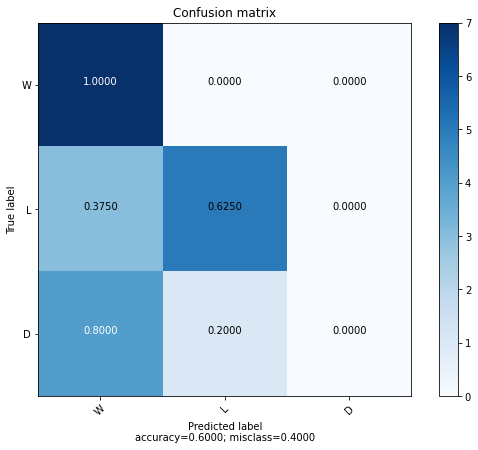

In [194]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



target_names = ['W','L','D']
cm = confusion_matrix(y_test,y_pred,labels=target_names)
plot_confusion_matrix(cm,target_names)